# Denoising Test for CNN + Conv2d_NN

In [1]:
import sys 
sys.path.append('../')
import time
import os 


import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary 

from Conv2d_NN_spatial import Conv2d_NN_spatial
from Conv2d_NN import Conv2d_NN
from pixelshuffle import PixelShuffle1D, PixelUnshuffle1D

import matplotlib.pyplot as plt


from data import MNIST_denoise, FashionMNIST_denoise, CIFAR10_denoise
from train import train_denoising_model, evaluate_denoising_accuracy, evaluate_accuracy_psnr


### MNIST + FashionMNIST + CIFAR10 Data

Files already downloaded and verified
Files already downloaded and verified


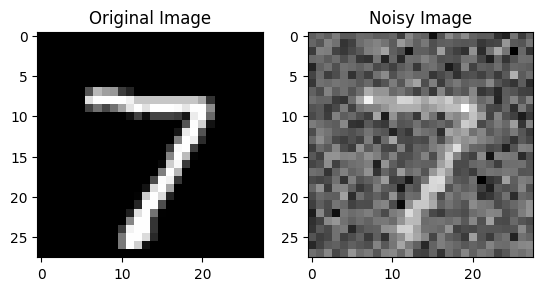

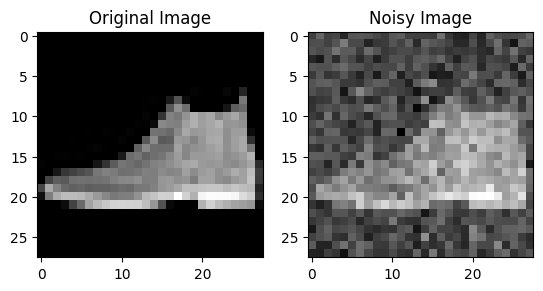

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


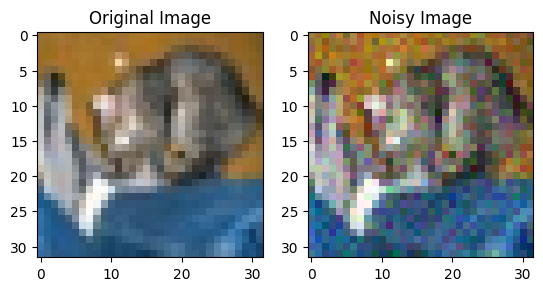

In [2]:
mnist = MNIST_denoise(noise_std=0.3)
fashionmnist = FashionMNIST_denoise(noise_std=0.3)
cifar10 = CIFAR10_denoise(noise_std=0.3)



mnist.visual()
fashionmnist.visual()
cifar10.visual()


In [3]:
import matplotlib.pyplot as plt

def visual(model, test_loader):
    for test_data in test_loader:
        noisy_img, img = test_data[0], test_data[1]
        
        # Select the first image in the batch
        noisy_img = noisy_img[0]
        img = img[0]

        output_img = model(noisy_img.unsqueeze(0).to('mps'))  # Add batch dimension back for the model

        plt.subplot(1, 3, 1)
        plt.title('Noisy image')
        plt.imshow(noisy_img.squeeze().cpu().numpy(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title('Denoised image')
        plt.imshow(output_img.squeeze().detach().cpu().numpy(), cmap='gray')
        
        plt.subplot(1, 3, 3)
        plt.title('Original image')
        plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')

        plt.show()
        break  # Remove this break to visualize more images



## I. MNIST + Fashion MNIST TEST

### i. Conv2d_NN all sample Model

In [4]:
# Model 
conv2d_nn_all = nn.Sequential(
   Conv2d_NN(
      in_channels=1,
      out_channels=5,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2
   ), 
   Conv2d_NN(
      in_channels=5,
      out_channels=10,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2
   ),
   Conv2d_NN(
      in_channels=10,
      out_channels=20,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2
   ),
   Conv2d_NN(
      in_channels=20,
      out_channels=1,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2
   )
   
   
).to('cpu')
   

from torchsummary import summary
summary(conv2d_nn_all, (1, 28, 28))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 4, 196]               0
            Conv1d-2              [-1, 20, 196]             660
              ReLU-3              [-1, 20, 196]               0
         Conv1d_NN-4              [-1, 20, 196]               0
         Conv2d_NN-5            [-1, 5, 28, 28]               0
           Flatten-6              [-1, 20, 196]               0
            Conv1d-7              [-1, 40, 196]           6,440
              ReLU-8              [-1, 40, 196]               0
         Conv1d_NN-9              [-1, 40, 196]               0
        Conv2d_NN-10           [-1, 10, 28, 28]               0
          Flatten-11              [-1, 40, 196]               0
           Conv1d-12              [-1, 80, 196]          25,680
             ReLU-13              [-1, 80, 196]               0
        Conv1d_NN-14              [-1, 

In [5]:
# MNIST results 
conv2d_nn_all.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_all.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_all, mnist.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_all, mnist.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_all, mnist.test_loader, criterion)

Epoch 1, Time: 65.28786492347717, Loss: 0.043473642176465946
Epoch 2, Time: 67.62178111076355, Loss: 0.018986572279159956
Epoch 3, Time: 64.4481258392334, Loss: 0.018366926715079782
Epoch 4, Time: 63.52916622161865, Loss: 0.018124673328896574
Epoch 5, Time: 63.94934701919556, Loss: 0.01799955464867768
Epoch 6, Time: 62.57458305358887, Loss: 0.017944842112312186
Epoch 7, Time: 62.003515005111694, Loss: 0.01793120179309456
Epoch 8, Time: 61.78710198402405, Loss: 0.017898469613289145
Epoch 9, Time: 61.786421060562134, Loss: 0.017902255656003063
Epoch 10, Time: 62.14556384086609, Loss: 0.01791902683945353

 Average epoch time: 63.51334700584412
Average loss on test set: 0.017882466304359163
Average PSNR on test set: 17.488593581375802


17.488593581375802

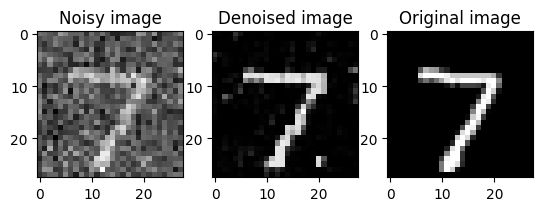

In [6]:
visual(conv2d_nn_all, mnist.test_loader)

In [7]:
# Fashion MNIST results
conv2d_nn_all.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_all.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_all, fashionmnist.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_all, fashionmnist.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_all, fashionmnist.test_loader, criterion)

Epoch 1, Time: 63.984795331954956, Loss: 0.5888629489616036
Epoch 2, Time: 63.664604902267456, Loss: 0.5850909533404084
Epoch 3, Time: 63.71255397796631, Loss: 0.584477138735338
Epoch 4, Time: 63.52636909484863, Loss: 0.5842317688439701
Epoch 5, Time: 63.70403695106506, Loss: 0.5840899685044278
Epoch 6, Time: 64.54582095146179, Loss: 0.5840258092514233
Epoch 7, Time: 65.34283113479614, Loss: 0.5839338134219652
Epoch 8, Time: 63.691871881484985, Loss: 0.5839140649670477
Epoch 9, Time: 63.704423904418945, Loss: 0.5839071517814197
Epoch 10, Time: 63.654947996139526, Loss: 0.5839232182833177

 Average epoch time: 63.95322561264038
Average loss on test set: 0.5818596565799349
Average PSNR on test set: 2.354026221925286


2.354026221925286

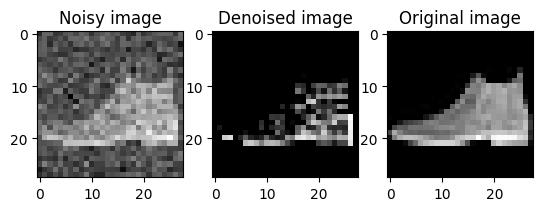

In [8]:
visual(conv2d_nn_all, fashionmnist.test_loader)

### ii. Conv2d NN N (10) Sample Model 

In [9]:
# Model 
conv2d_nn_n = nn.Sequential(
   Conv2d_NN(
      in_channels=1,
      out_channels=5,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples = 10
      
   ), 
   Conv2d_NN(
      in_channels=5,
      out_channels=10,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples = 10
   ),
   Conv2d_NN(
      in_channels=10,
      out_channels=20,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples = 10
   ), 
   Conv2d_NN(
      in_channels=20,
      out_channels=1,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples = 10
   )
   
).to('cpu')
   

from torchsummary import summary
summary(conv2d_nn_n, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 4, 196]               0
            Conv1d-2              [-1, 20, 196]             660
              ReLU-3              [-1, 20, 196]               0
         Conv1d_NN-4              [-1, 20, 196]               0
         Conv2d_NN-5            [-1, 5, 28, 28]               0
           Flatten-6              [-1, 20, 196]               0
            Conv1d-7              [-1, 40, 196]           6,440
              ReLU-8              [-1, 40, 196]               0
         Conv1d_NN-9              [-1, 40, 196]               0
        Conv2d_NN-10           [-1, 10, 28, 28]               0
          Flatten-11              [-1, 40, 196]               0
           Conv1d-12              [-1, 80, 196]          25,680
             ReLU-13              [-1, 80, 196]               0
        Conv1d_NN-14              [-1, 

In [10]:
# MNIST results 
conv2d_nn_n.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_n.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_n, mnist.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_n, mnist.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_n, mnist.test_loader, criterion)

Epoch 1, Time: 67.6634349822998, Loss: 0.022944519986340933
Epoch 2, Time: 64.93854284286499, Loss: 0.013789165468175591
Epoch 3, Time: 65.68952417373657, Loss: 0.013380690863026358
Epoch 4, Time: 67.02059602737427, Loss: 0.013284285456490224
Epoch 5, Time: 69.29969096183777, Loss: 0.013226679927393445
Epoch 6, Time: 70.98887395858765, Loss: 0.013169775325765234
Epoch 7, Time: 72.61157608032227, Loss: 0.013156562040784338
Epoch 8, Time: 73.62290787696838, Loss: 0.013154005464007542
Epoch 9, Time: 74.44248604774475, Loss: 0.01313476151089742
Epoch 10, Time: 75.04440808296204, Loss: 0.013137804944989588

 Average epoch time: 70.13220410346985
Average loss on test set: 0.013140535948999749
Average PSNR on test set: 18.81372431129407


18.81372431129407

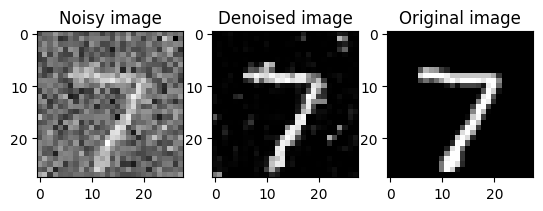

In [11]:
visual(conv2d_nn_n, mnist.test_loader)

In [12]:
# Fashion MNIST results
conv2d_nn_n.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_n.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_n, fashionmnist.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_n, fashionmnist.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_n, fashionmnist.test_loader, criterion)

Epoch 1, Time: 65.86322402954102, Loss: 0.6585375357792576
Epoch 2, Time: 65.79783701896667, Loss: 0.6563492682315647
Epoch 3, Time: 65.97250890731812, Loss: 0.6562311656947838
Epoch 4, Time: 65.80704188346863, Loss: 0.6561117439763124
Epoch 5, Time: 65.64657783508301, Loss: 0.656067612455852
Epoch 6, Time: 65.60667490959167, Loss: 0.6560558464481379
Epoch 7, Time: 66.15221691131592, Loss: 0.6475867519119402
Epoch 8, Time: 66.73231482505798, Loss: 0.6307539474099938
Epoch 9, Time: 66.62219285964966, Loss: 0.6306797764829989
Epoch 10, Time: 66.73516798019409, Loss: 0.6306541586862698

 Average epoch time: 66.09357571601868
Average loss on test set: 0.6282192347156015
Average PSNR on test set: 2.020304007894674


2.020304007894674

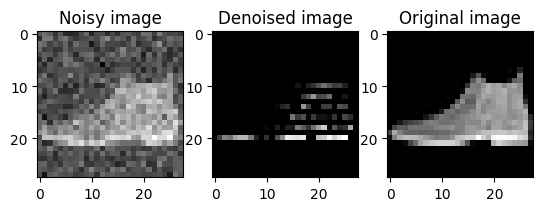

In [13]:
visual(conv2d_nn_n, fashionmnist.test_loader)

### iii. Conv2d NN Spatial samples Model

In [14]:
# Model 
conv2d_nn_spatial = nn.Sequential(
   Conv2d_NN_spatial(
      in_channels=1,
      out_channels=5,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples=3
      
   ), 
   Conv2d_NN_spatial(
      in_channels=5,
      out_channels=10,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples=3
   ),
   Conv2d_NN_spatial(
      in_channels=10,
      out_channels=20,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples=3
   ), 
   Conv2d_NN_spatial(
      in_channels=20,
      out_channels=1,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples=3
   )
   
).to('cpu')
   

from torchsummary import summary
summary(conv2d_nn_spatial, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 1, 784]               0
            Conv1d-2               [-1, 5, 784]              45
              ReLU-3               [-1, 5, 784]               0
 Conv1d_NN_spatial-4               [-1, 5, 784]               0
 Conv2d_NN_spatial-5            [-1, 5, 28, 28]               0
           Flatten-6               [-1, 5, 784]               0
            Conv1d-7              [-1, 10, 784]             410
              ReLU-8              [-1, 10, 784]               0
 Conv1d_NN_spatial-9              [-1, 10, 784]               0
Conv2d_NN_spatial-10           [-1, 10, 28, 28]               0
          Flatten-11              [-1, 10, 784]               0
           Conv1d-12              [-1, 20, 784]           1,620
             ReLU-13              [-1, 20, 784]               0
Conv1d_NN_spatial-14              [-1, 

In [15]:
# MNIST results 
conv2d_nn_spatial.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_spatial.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_spatial, mnist.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_spatial, mnist.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_spatial, mnist.test_loader, criterion)

Epoch 1, Time: 144.87511706352234, Loss: 0.09498844501465115
Epoch 2, Time: 143.51203727722168, Loss: 0.0949568455216727
Epoch 3, Time: 143.76518607139587, Loss: 0.09494660233161342
Epoch 4, Time: 143.49508500099182, Loss: 0.09494056463686389
Epoch 5, Time: 143.62005710601807, Loss: 0.0949390645125019
Epoch 6, Time: 138.92741775512695, Loss: 0.0949416630653176
Epoch 7, Time: 136.37744212150574, Loss: 0.09494419963057361
Epoch 8, Time: 135.752295255661, Loss: 0.09494207290285178
Epoch 9, Time: 135.58524990081787, Loss: 0.09493886831123183
Epoch 10, Time: 135.75034880638123, Loss: 0.09493639636268494

 Average epoch time: 140.16602363586426
Average loss on test set: 0.0965922497165431
Average PSNR on test set: 10.191046654039129


10.191046654039129

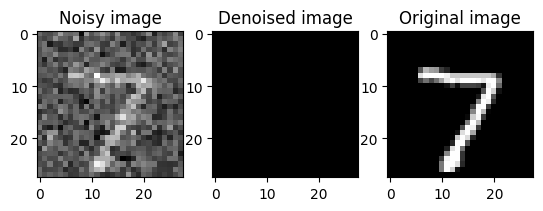

In [16]:
visual(conv2d_nn_spatial, mnist.test_loader)

In [17]:
# Fashion MNIST results
conv2d_nn_spatial.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_spatial.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_spatial, fashionmnist.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_spatial, fashionmnist.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_spatial, fashionmnist.test_loader, criterion)

Epoch 1, Time: 122.98798274993896, Loss: 0.6816056766616765
Epoch 2, Time: 122.85929322242737, Loss: 0.6816069273425064
Epoch 3, Time: 122.80908966064453, Loss: 0.6816076230265693
Epoch 4, Time: 122.91644072532654, Loss: 0.6816198277448032
Epoch 5, Time: 124.82577896118164, Loss: 0.6816204887336251
Epoch 6, Time: 125.01908802986145, Loss: 0.6816231463509582
Epoch 7, Time: 125.9403281211853, Loss: 0.6816151800440319
Epoch 8, Time: 125.48776292800903, Loss: 0.6816224912717652
Epoch 9, Time: 123.41376781463623, Loss: 0.6816106931741304
Epoch 10, Time: 123.07766699790955, Loss: 0.6816395964703834

 Average epoch time: 123.93371992111206
Average loss on test set: 0.678826325638279
Average PSNR on test set: 1.6837401557120548


1.6837401557120548

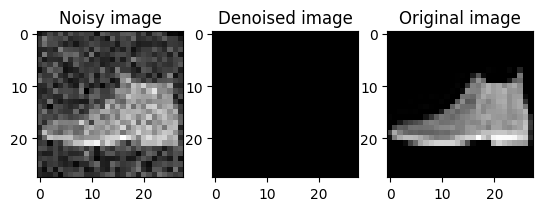

In [18]:
visual(conv2d_nn_spatial, fashionmnist.test_loader)

### iv. CNN Model 1 

In [19]:
cnn = nn.Sequential(
   nn.Conv2d(
      in_channels=1,
      out_channels=5,
      kernel_size=3
   ), 
   nn.ReLU(),
   nn.Conv2d(
      in_channels=5,
      out_channels=10,
      kernel_size=3
   ), 
   nn.ReLU(),
   nn.Conv2d(
      in_channels=10,
      out_channels=20,
      kernel_size=3
   ), 
   nn.ReLU(),
   nn.Conv2d(
      in_channels=20,
      out_channels=1,
      kernel_size=3, 
      padding=4
   )
   
).to('cpu')
   

from torchsummary import summary
summary(cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              50
              ReLU-2            [-1, 5, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             460
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,820
              ReLU-6           [-1, 20, 22, 22]               0
            Conv2d-7            [-1, 1, 28, 28]             181
Total params: 2,511
Trainable params: 2,511
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.01
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [20]:
# MNIST results 
cnn.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(cnn, mnist.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(cnn, mnist.test_loader, criterion)
evaluate_accuracy_psnr(cnn, mnist.test_loader, criterion)

Epoch 1, Time: 9.061133861541748, Loss: 0.010921309233458439
Epoch 2, Time: 8.129202842712402, Loss: 0.005767743361355273
Epoch 3, Time: 8.019099712371826, Loss: 0.005559599901765966
Epoch 4, Time: 8.091548919677734, Loss: 0.005434636398951319
Epoch 5, Time: 7.983135938644409, Loss: 0.005353372930281007
Epoch 6, Time: 7.983276128768921, Loss: 0.005293992904028786
Epoch 7, Time: 7.880242109298706, Loss: 0.0052360307037043995
Epoch 8, Time: 8.004434823989868, Loss: 0.005207474312202922
Epoch 9, Time: 7.815184831619263, Loss: 0.005163896793642564
Epoch 10, Time: 8.052079200744629, Loss: 0.005140850754347501

 Average epoch time: 8.10193383693695
Average loss on test set: 0.005226741877093816
Average PSNR on test set: 22.828160668634304


22.828160668634304

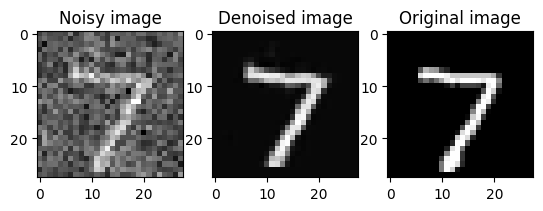

In [21]:
visual(cnn, mnist.test_loader)

In [22]:
# Fashion MNIST results
cnn.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

criterion = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(cnn, fashionmnist.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(cnn, fashionmnist.test_loader, criterion)
evaluate_accuracy_psnr(cnn, fashionmnist.test_loader, criterion)

Epoch 1, Time: 8.72569227218628, Loss: 0.1552590991594771
Epoch 2, Time: 8.608338117599487, Loss: 0.07969243360607862
Epoch 3, Time: 8.605435132980347, Loss: 0.07660107718887868
Epoch 4, Time: 8.59990382194519, Loss: 0.07565862468596715
Epoch 5, Time: 8.617732048034668, Loss: 0.07497715089382774
Epoch 6, Time: 8.489712238311768, Loss: 0.0745173253134878
Epoch 7, Time: 8.174116134643555, Loss: 0.07418152572773794
Epoch 8, Time: 8.31396198272705, Loss: 0.07394777431782247
Epoch 9, Time: 8.4131920337677, Loss: 0.0737467397179113
Epoch 10, Time: 8.144522905349731, Loss: 0.07357022060212423

 Average epoch time: 8.469260668754577
Average loss on test set: 0.07381373171688645
Average PSNR on test set: 11.328636625010496


11.328636625010496

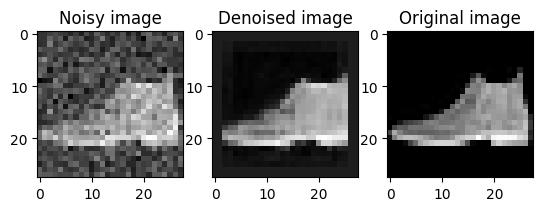

In [23]:
visual(cnn, fashionmnist.test_loader)

## II. CIFAR TEST

In [24]:
import matplotlib.pyplot as plt
import torch

def visual(model, test_loader):
    for test_data in test_loader:
        noisy_img, img = test_data[0], test_data[1]
        
        # Select the first image in the batch
        noisy_img = noisy_img[0]
        img = img[0]

        # Move tensors to MPS device
        noisy_img = noisy_img.to('mps')
        img = img.to('mps')

        # Get the model output
        output_img = model(noisy_img.unsqueeze(0))

        # Move tensors back to CPU and detach
        noisy_img = noisy_img.cpu().detach()
        output_img = output_img.squeeze(0).cpu().detach()
        img = img.cpu().detach()

        # Permute dimensions to (height, width, channels) for matplotlib
        noisy_img = noisy_img.permute(1, 2, 0)
        output_img = output_img.permute(1, 2, 0)
        img = img.permute(1, 2, 0)

        # Denormalize the images (assuming CIFAR-10 normalization)
        mean = torch.tensor([0.4914, 0.4822, 0.4465])
        std = torch.tensor([0.2023, 0.1994, 0.2010])
        noisy_img = noisy_img * std + mean
        output_img = output_img * std + mean
        img = img * std + mean

        plt.figure(figsize=(15, 5))  # Adjust the figure size if needed

        plt.subplot(1, 3, 1)
        plt.title('Noisy image')
        plt.imshow(noisy_img.numpy())

        plt.subplot(1, 3, 2)
        plt.title('Denoised image')
        plt.imshow(output_img.numpy())
        
        plt.subplot(1, 3, 3)
        plt.title('Original image')
        plt.imshow(img.numpy())

        plt.show()
        break  # Remove this break to visualize more images



### i. Conv2d_NN all sample Model

In [25]:
# Model 
conv2d_nn_all = nn.Sequential(
   Conv2d_NN(
      in_channels=3,
      out_channels=5,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2
   ), 
   Conv2d_NN(
      in_channels=5,
      out_channels=10,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2
   ),
   Conv2d_NN(
      in_channels=10,
      out_channels=20,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2
   ),
   Conv2d_NN(
      in_channels=20,
      out_channels=3,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2
   )
   
).to('cpu')
   

from torchsummary import summary
summary(conv2d_nn_all, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1              [-1, 12, 256]               0
            Conv1d-2              [-1, 20, 256]           1,940
              ReLU-3              [-1, 20, 256]               0
         Conv1d_NN-4              [-1, 20, 256]               0
         Conv2d_NN-5            [-1, 5, 32, 32]               0
           Flatten-6              [-1, 20, 256]               0
            Conv1d-7              [-1, 40, 256]           6,440
              ReLU-8              [-1, 40, 256]               0
         Conv1d_NN-9              [-1, 40, 256]               0
        Conv2d_NN-10           [-1, 10, 32, 32]               0
          Flatten-11              [-1, 40, 256]               0
           Conv1d-12              [-1, 80, 256]          25,680
             ReLU-13              [-1, 80, 256]               0
        Conv1d_NN-14              [-1, 

In [26]:
# CIFAR10 results 
conv2d_nn_all.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_all.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_all, cifar10.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_all, cifar10.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_all, cifar10.test_loader, criterion)


Epoch 1, Time: 66.35256004333496, Loss: 0.9732642488558884
Epoch 2, Time: 64.82321691513062, Loss: 0.9557384371452624
Epoch 3, Time: 65.17632484436035, Loss: 0.9530413268929552
Epoch 4, Time: 66.18788504600525, Loss: 0.9524079747974415
Epoch 5, Time: 66.63051223754883, Loss: 0.951481716940775
Epoch 6, Time: 65.23787903785706, Loss: 0.9509629461618946
Epoch 7, Time: 64.45111298561096, Loss: 0.9507594636791502
Epoch 8, Time: 64.22049498558044, Loss: 0.950507531538034
Epoch 9, Time: 64.4704258441925, Loss: 0.9502522785340428
Epoch 10, Time: 65.51606917381287, Loss: 0.9501749188698771

 Average epoch time: 65.30664811134338
Average loss on test set: 0.937303785685521
Average PSNR on test set: 0.2932453243489003


0.2932453243489003

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


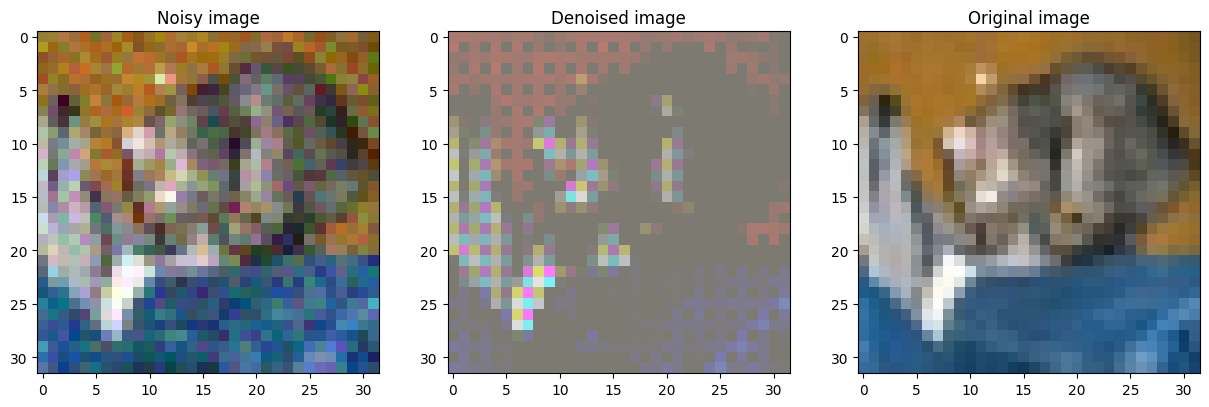

In [27]:
visual(conv2d_nn_all, cifar10.test_loader)

### ii. Conv2d NN N (10) Sample Model

In [28]:
# Model 
conv2d_nn_n = nn.Sequential(
   Conv2d_NN(
      in_channels=3,
      out_channels=5,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples = 10
      
   ), 
   Conv2d_NN(
      in_channels=5,
      out_channels=10,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples = 10
   ),
   Conv2d_NN(
      in_channels=10,
      out_channels=20,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples = 10
   ),
   Conv2d_NN(
      in_channels=20,
      out_channels=3,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples = 10
   )
   
).to('cpu')
   

from torchsummary import summary
summary(conv2d_nn_n, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1              [-1, 12, 256]               0
            Conv1d-2              [-1, 20, 256]           1,940
              ReLU-3              [-1, 20, 256]               0
         Conv1d_NN-4              [-1, 20, 256]               0
         Conv2d_NN-5            [-1, 5, 32, 32]               0
           Flatten-6              [-1, 20, 256]               0
            Conv1d-7              [-1, 40, 256]           6,440
              ReLU-8              [-1, 40, 256]               0
         Conv1d_NN-9              [-1, 40, 256]               0
        Conv2d_NN-10           [-1, 10, 32, 32]               0
          Flatten-11              [-1, 40, 256]               0
           Conv1d-12              [-1, 80, 256]          25,680
             ReLU-13              [-1, 80, 256]               0
        Conv1d_NN-14              [-1, 

In [29]:
# CIFAR10 results 
conv2d_nn_n.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_n.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_n, cifar10.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_n, cifar10.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_n, cifar10.test_loader, criterion)


Epoch 1, Time: 83.24014902114868, Loss: 0.8200912016736882
Epoch 2, Time: 83.35238814353943, Loss: 0.7498289973229704
Epoch 3, Time: 84.5896167755127, Loss: 0.7384989914077017
Epoch 4, Time: 83.14832806587219, Loss: 0.7373505332280913
Epoch 5, Time: 82.859619140625, Loss: 0.7364272450851967
Epoch 6, Time: 83.1419038772583, Loss: 0.7349725698723513
Epoch 7, Time: 82.98085975646973, Loss: 0.7344071012933541
Epoch 8, Time: 82.77439308166504, Loss: 0.7343045015774115
Epoch 9, Time: 82.84264516830444, Loss: 0.7342305744395536
Epoch 10, Time: 83.15469288825989, Loss: 0.7341859365058372

 Average epoch time: 83.20845959186553
Average loss on test set: 0.717414370008335
Average PSNR on test set: 1.4645339616924336


1.4645339616924336

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


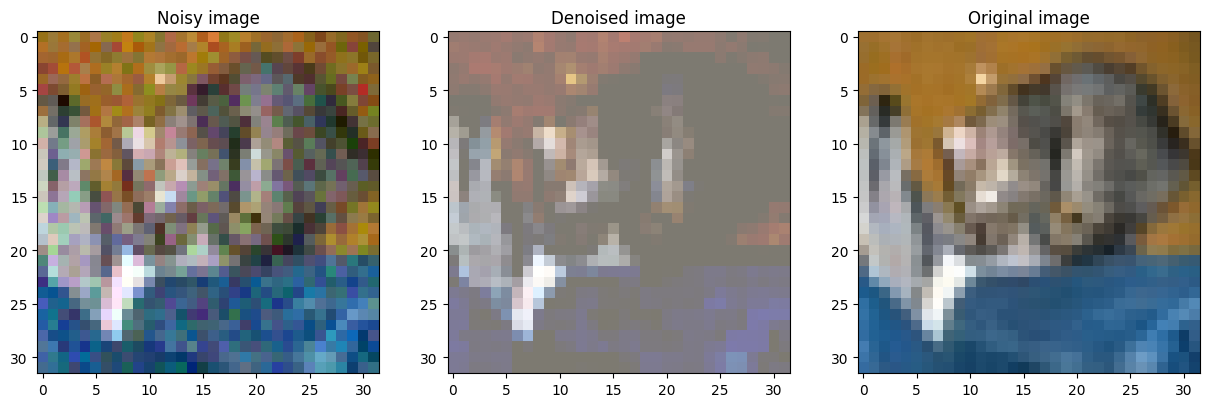

In [30]:
visual(conv2d_nn_n, cifar10.test_loader)

### iii. Conv2d NN Spatial samples Model

In [31]:
# Model 
conv2d_nn_spatial = nn.Sequential(
   Conv2d_NN_spatial(
      in_channels=3,
      out_channels=5,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples=3
      
   ), 
   Conv2d_NN_spatial(
      in_channels=5,
      out_channels=10,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples=3
   ),
   Conv2d_NN_spatial(
      in_channels=10,
      out_channels=20,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples=3
   ),
   Conv2d_NN_spatial(
      in_channels=20,
      out_channels=3,
      K=8,
      stride=8,
      padding=0,
      shuffle_scale=2, 
      samples=3
   )
   
).to('cpu')
   

from torchsummary import summary
summary(conv2d_nn_spatial, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1              [-1, 3, 1024]               0
            Conv1d-2              [-1, 5, 1024]             125
              ReLU-3              [-1, 5, 1024]               0
 Conv1d_NN_spatial-4              [-1, 5, 1024]               0
 Conv2d_NN_spatial-5            [-1, 5, 32, 32]               0
           Flatten-6              [-1, 5, 1024]               0
            Conv1d-7             [-1, 10, 1024]             410
              ReLU-8             [-1, 10, 1024]               0
 Conv1d_NN_spatial-9             [-1, 10, 1024]               0
Conv2d_NN_spatial-10           [-1, 10, 32, 32]               0
          Flatten-11             [-1, 10, 1024]               0
           Conv1d-12             [-1, 20, 1024]           1,620
             ReLU-13             [-1, 20, 1024]               0
Conv1d_NN_spatial-14             [-1, 2

In [32]:
# CIFAR10 results 
conv2d_nn_spatial.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(conv2d_nn_spatial.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(conv2d_nn_spatial, cifar10.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(conv2d_nn_spatial, cifar10.test_loader, criterion)
evaluate_accuracy_psnr(conv2d_nn_spatial, cifar10.test_loader, criterion)


Epoch 1, Time: 148.9191129207611, Loss: 1.5089699032971315
Epoch 2, Time: 148.4608461856842, Loss: 1.5068778488642114
Epoch 3, Time: 148.42934203147888, Loss: 1.5051953949586814
Epoch 4, Time: 147.89979219436646, Loss: 1.5038713657337686
Epoch 5, Time: 150.15600419044495, Loss: 1.460111552492127
Epoch 6, Time: 150.54601097106934, Loss: 1.4546179463491415
Epoch 7, Time: 150.8197808265686, Loss: 1.4523027906637362
Epoch 8, Time: 150.81453704833984, Loss: 1.4503877275740094
Epoch 9, Time: 150.94526982307434, Loss: 1.4489831569249674
Epoch 10, Time: 151.09146285057068, Loss: 1.4473405869110771

 Average epoch time: 149.80821590423585
Average loss on test set: 1.4382300346520296
Average PSNR on test set: -1.572183976127843


-1.572183976127843

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


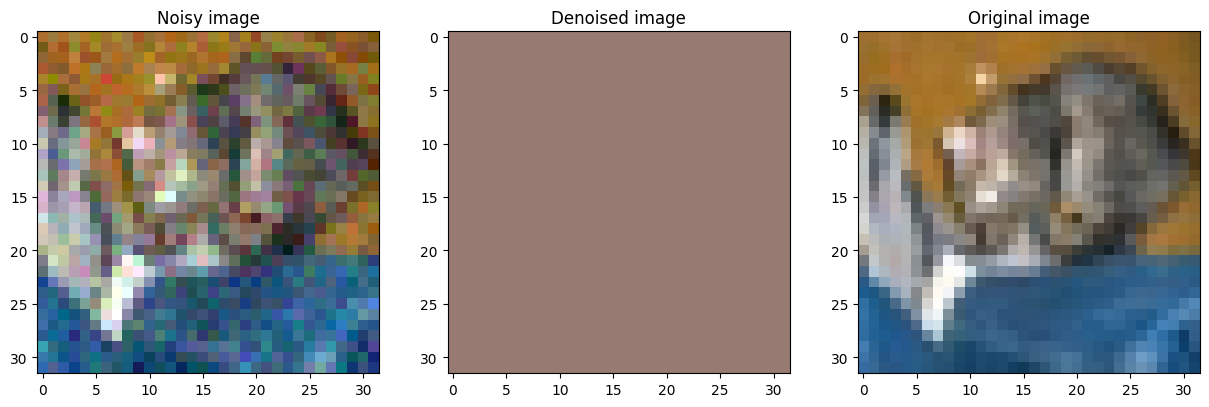

In [33]:
visual(conv2d_nn_spatial, cifar10.test_loader)

### iv. CNN Model 1 

In [34]:
cnn = nn.Sequential(
   nn.Conv2d(
      in_channels=3,
      out_channels=5,
      kernel_size=3
   ), 
   nn.ReLU(),
   nn.Conv2d(
      in_channels=5,
      out_channels=10,
      kernel_size=3
   ), 
   nn.ReLU(),
   nn.Conv2d(
      in_channels=10,
      out_channels=20,
      kernel_size=3
   ), 
   nn.Conv2d(
      in_channels=20,
      out_channels=3,
      kernel_size=3, 
      padding=4
   )
   
).to('cpu')
   

from torchsummary import summary
summary(cnn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 30, 30]             140
              ReLU-2            [-1, 5, 30, 30]               0
            Conv2d-3           [-1, 10, 28, 28]             460
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 20, 26, 26]           1,820
            Conv2d-6            [-1, 3, 32, 32]             543
Total params: 2,963
Trainable params: 2,963
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.31
Params size (MB): 0.01
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


In [35]:
# CIFAR10 results 
cnn.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(cnn, cifar10.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(cnn, cifar10.test_loader, criterion)
evaluate_accuracy_psnr(cnn, cifar10.test_loader, criterion)


Epoch 1, Time: 10.584983825683594, Loss: 0.5598764417650145
Epoch 2, Time: 10.118472814559937, Loss: 0.5110384917548855
Epoch 3, Time: 9.893332958221436, Loss: 0.5064366189262751
Epoch 4, Time: 10.191383838653564, Loss: 0.5050704278756896
Epoch 5, Time: 10.130647897720337, Loss: 0.5042737045937487
Epoch 6, Time: 9.887742042541504, Loss: 0.5035617150309141
Epoch 7, Time: 10.197021245956421, Loss: 0.5028977260717651
Epoch 8, Time: 9.616112232208252, Loss: 0.5025317330875665
Epoch 9, Time: 9.554756164550781, Loss: 0.5019469607973952
Epoch 10, Time: 9.981447219848633, Loss: 0.5015904652645521

 Average epoch time: 10.015590023994445
Average loss on test set: 0.49761147483898577
Average PSNR on test set: 3.0432483800657235


3.0432483800657235

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


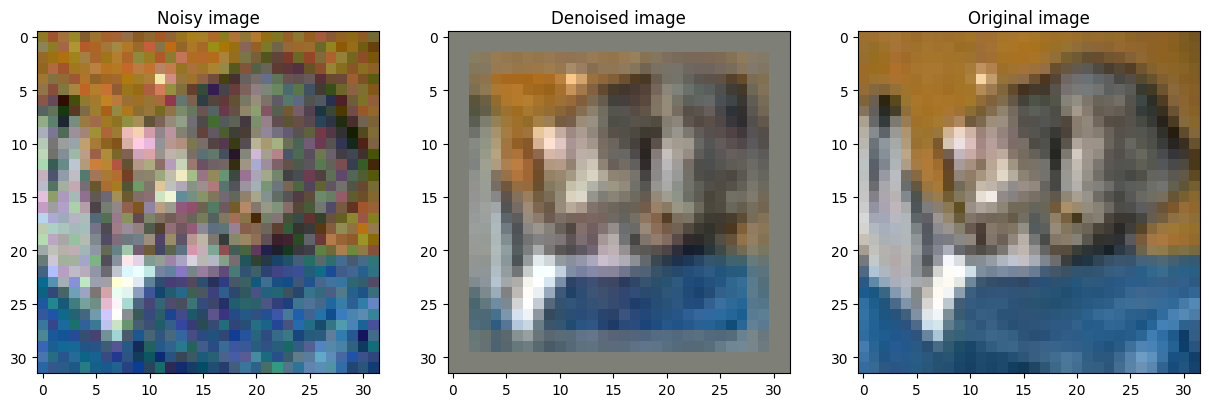

In [36]:
visual(cnn, cifar10.test_loader)